In [1]:
#A continuación importamos las librerias que utilizaremos. 
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib import cm
import math
from tqdm import tqdm

# Taller 2: Métodos Computacionales
### Estudiantes: Andrés Hernández (201329363)    Francisco Díaz (201912252)

## Generador de números aleatorios
**1.** Un test simple para probar la calidad de un generador de eventos es evaluar las correlaciones con los $k$-vecinos más cercanos donde $k \sim 20 $
$$
C(k) = \frac{1}{N} \sum_{i=1}^{N} x_{i}x_{i+k} \; \; \; (k = 0,1,2,...)
$$


a) Implemente un código (en C++ y en Python) que estime los coeficientes de correlación para los primeros $k=20$ vecinos. Use $N = 10^3$ eventos para ambos generadores ($simple$ y $drand48$ ).

In [2]:
#Definimos la clase generadora de número aleatorios.

class MyRandom():
    def __init__(self, seed = 15 , method = 'simple'):
        
        self.r = seed
        self.method = method
        
        if method == 'simple':
            self.a = 57 
            self.c = 1
            self.M = 265
        elif method == "drand48":
            self.a = int('5DEECE66D',16) 
            self.c = int('B', 16)
            self.M = 2 **48
        else:
            print('Generador no reconocido')
    
    def Random(self):
        
        r= (self.a*self.r + self.c)%self.M
        self.r = r
        
        return r/float(self.M)
   
    def Correlation(self, sample_, k_, seed_ = 32 , method_ = 'simple'):
        
        rand = MyRandom(seed = seed_ , method = method_)
        Npoints = len(sample_)            
        Ck = []
        
        for k in range(0,k_):
            sum = 0
            
            for j in range (Npoints-k-1):        
                sum += sample_[j]*sample_[j+k+1]
            sum *= 1/Npoints
        
            Ck.append(sum)               
        
        return Ck

b) Haga una gráfica entre el valor del coeficiente $C(k)$ en función del momento de la distribución $k$. ¿Qué diferencia encuentra entre ambos generadores?


In [3]:
# Llenamos los dos arreglos con 1000 eventos aleatorios utilizando ambos generadores.

def FillPoints(Npoints_ , seed_ ,method_ ):
    
    rand = MyRandom(seed = seed_ , method = method_)
    
    points = np.zeros(Npoints_)
    
    for i in tqdm(range(Npoints_)):
        points[i] = rand.Random()
        
    return points

Npoints= int(1e3)

method1 = 'simple'
method2 = 'drand48'
rand1 =  MyRandom( seed = 6625 , method=method1)
sample1 = FillPoints(Npoints,  6625 , method1)
rand2 =  MyRandom( seed = 6625 , method=method2)
sample2 = FillPoints(Npoints,  6625 , method2)

# Ahora, calculamos los coeficientes de correlación C(k) de ambos métodos para k = 20.

k = 20
Ck1 = rand1.Correlation(sample1,k ,6625, method1)
Ck2 = rand2.Correlation(sample2,k , 6625, method2)

100%|██████████| 1000/1000 [00:00<00:00, 250301.61it/s]


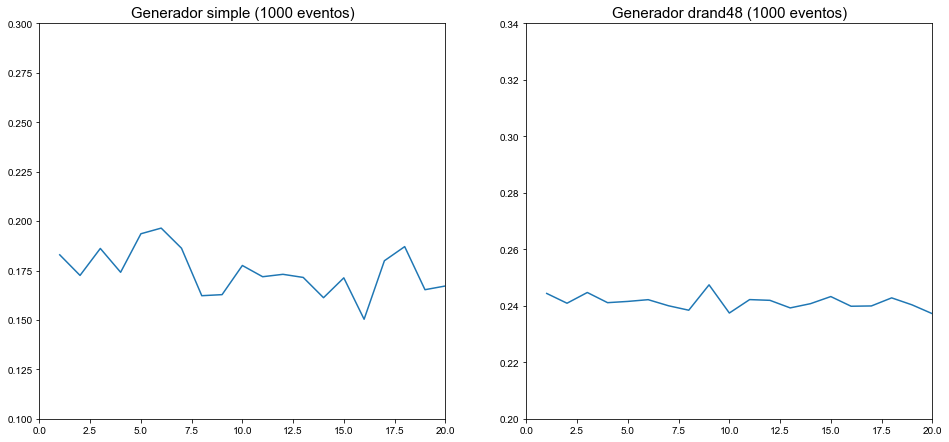

In [4]:
x = np.linspace(1, k , k)

fig = plt.figure(figsize=(16,16))
ax1= fig.add_subplot(2,2,1)
ax2= fig.add_subplot(2,2,2)

ax1.plot(x,Ck1)
ax2.plot(x,Ck2)
ax1.set_xlim(0,k)
ax1.set_ylim(0.1,0.3)
ax1.set_title("Generador simple ("+str(Npoints)+" eventos)", fontsize = "15")
ax2.set_xlim(0,k)
ax2.set_ylim(0.2,0.34)
ax2.set_title("Generador drand48 ("+str(Npoints)+" eventos)", fontsize = "15")


plt.style.use('seaborn-whitegrid')
plt.show()

## 2. Generación 3D de eventos
**1.** Escrbia un código que genere una secuencia uniforme de eventos contenidos en una esfera de radio R = 2 como se muestra en la fígura.

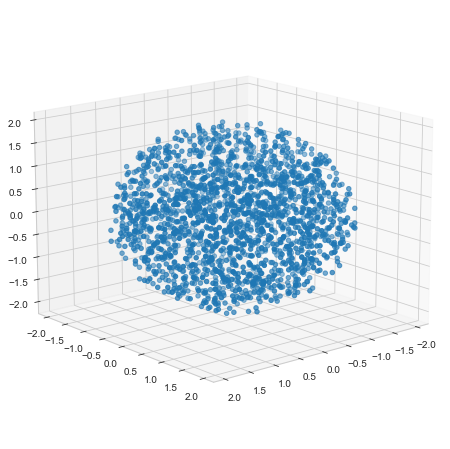

In [5]:
#Primero definimos la función generadora de puntos dentro de la esfera.

def CreateSphere(Npoints, R):
    
    X = []
    Y = []
    Z = []

    r = 0.
    theta = 0.
    phi = 0.
    
    for i in range(Npoints):
        
        phi = np.random.uniform(0.,2*np.pi)
        costheta = np.random.uniform(-1.,1.)
        theta = np.arccos(costheta)
        u = np.random.rand()
        
        r = R*u**(1./3.)
        
        X = np.append(X, r*np.cos(phi)*np.sin(theta))
        Y = np.append(Y, r*np.sin(phi)*np.sin(theta))
        Z = np.append(Z, r*np.cos(theta))
        
    return X,Y,Z

#Ahora graficamos los puntos para el radio en específico.

N, R =  int(2e3), 2
data_sphere = np.array(CreateSphere(N,R))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1,projection='3d')

ax.view_init(15,50)
ax.scatter(data_sphere[0],data_sphere[1],data_sphere[2])
plt.show()

## 3. Integración MonteCarlo
**1.** Usando la generación de puntos sobre una esfera estime la siguiente integral (en C++ y en python), para $\{x^{2}+y^{2}+z^{2} \leq 1 \} $:
$$
\int \int \int e^{\sqrt{x^{2}+y^{2}+z^{2}}} dxdydz = 4 \pi( e-2)
$$

In [6]:
#A continuación utilizaremos dos métodos de integración de Montecarlo

#Definimos la función que queremos integrar y los límites de integración.
# Nótese que hemos realizado un cambio en el sistema de coordenadas, cartesianas -> esféricas.
def f(r,theta):
    return (r**2)*np.exp(r)*np.sin(theta)
limits = (np.pi)*(2*np.pi)

#Método 1: Integración directa de Montecarlo.
def IntegralMC1(Npoints_ = int(1e4), R_ = 1):
    R = np.random.rand(Npoints_)
    Theta = np.random.rand(Npoints_)*np.pi
    F= f(R,Theta)
    return np.average(F)*limits

#Método 2: Integración con método de aceptación y rechazo.
def IntegralMC2(Npoints_ = int(1e4), R_ = 1):
    R = np.random.rand(Npoints_)
    Theta = np.random.rand(Npoints_)*np.pi
    FY = np.random.rand(Npoints_)*np.exp(1) 
    
    Max = np.exp(1) 
    Ninside = 0   
    for i in range(int(Npoints_)):
    
        yi = FY[i]
    
        if yi < f(R[i],Theta[i]):
        
            Ninside +=1 
        
    Eff = Ninside/float(Npoints_)
    return Max*Eff*limits

#Calculamos la integral utilizando ambos métodos.

Npoints = 1e5
R = 1
MC1I , MC2I = IntegralMC1(int(Npoints),R),IntegralMC2(int(Npoints),R)
IntegralReal = 4*np.pi*(np.exp(1)-2)

display(Latex('Valor estimado de la integral utilizando el primer método: ' + r'$I_{estimated} =$'+str(MC1I) ) )
display(Latex('Valor estimado de la integral utilizando el segundo método: ' + r'$I_{estimated} =$'+str(MC2I) ) )
display(Latex('Valor teórico de la integral utilizando las constantes de $numpy$ : ' + r'$I_{exact} =$'+str(IntegralReal) ) )

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

**2.** Haga una gráfica entre la precisión $\epsilon = (I_{estimated}/I_{exact})$ y el número de puntos muestrales, el cuál debe tener
un rango de valores adecuado para ver el comportamiento. ¿Qué dependecia se observa?

In [7]:
#Ahora calculamos la precisión para varios estimativos utilizando distintos número de puntos muestrales.

Npoints = np.int_(np.logspace(3,6,12))
print(Npoints)
e1 , e2 = [],[]
for i in Npoints:
    MC1I,MC2I = IntegralMC1(int(i),R),IntegralMC2(int(i),R)
    e1.append(MC1I/IntegralReal)
    e2.append(MC2I/IntegralReal)



[   1000    1873    3511    6579   12328   23101   43287   81113  151991
  284803  533669 1000000]


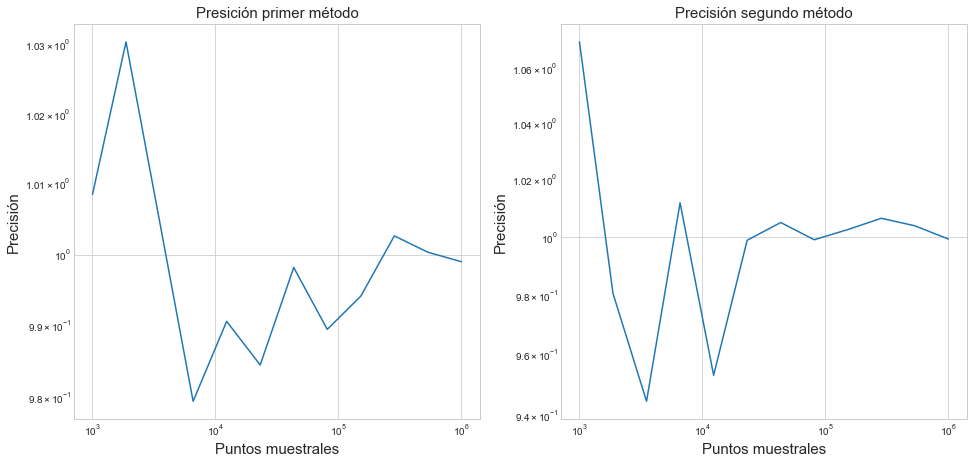

In [8]:
#Graficamos para evidenciar la dependencia.

fig = plt.figure(figsize=(16,16))
ax1= fig.add_subplot(2,2,1)
ax2= fig.add_subplot(2,2,2)

ax1.plot(Npoints,e1, label=r'$\varepsilon_{1}$')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Puntos muestrales', fontsize=15)
ax1.set_ylabel('Precisión', fontsize=15)
ax2.plot(Npoints,e2, label=r'$\varepsilon_{2}$')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('Puntos muestrales', fontsize=15)
ax2.set_ylabel('Precisión', fontsize=15)

ax1.set_title("Presición primer método", fontsize = "15")

ax2.set_title("Precisión segundo método", fontsize = "15")


plt.style.use('seaborn-whitegrid')
plt.show()


## 4. Metrópolis Hastings - Integración 
**1.** Definiendo el volumen d-dimensional $(V_{d})$ como:
$$
V_{d} = \int_{- \infty}^{\infty} \cos(||r||)e^{-||r||^{2}}dr^{d}
$$
donde $||r|| = \sqrt{\sum_{i=1}^{d} x_{i}^{2}}$ y $dr^{d} = dx_{1}...dx_{d}$. El volumen de normalización de esta función es $(2\pi \sigma ^{2})^{\frac{d}{2}}$, en este caso usar $\sigma = \frac{1}{\sqrt{2}} $ .
a) Usando el método de Metrópolis Hastings para $N = 10^{5}$ eventos, muestre que los volúmenes $d=2,3$ son respectivamente $V_{2} \approx = 1.817671646 $ y $V_{3} \approx 2.167233695 $ .

In [9]:
#Primero definimos las funciones que utilizaremos.

def WeightF(x_, sigma_):
    CDF = (1 + math.erf(x_/ (sigma_*np.sqrt(2))))/2
    return 3*(CDF**2)*(1/(sigma_*np.sqrt(2*np.pi)))*np.exp(-(1/2)*(x_/sigma_)**2)
def GetX(d):
    x = 2.0*(np.random.rand(d)-0.5)
    return np.sqrt(sum(x**2))
def Metropolis(r0_, Width=1.3, NSteps=int(1e5),d_ = 10 , sigma_=1/np.sqrt(2)):
    
    R = np.array([])
    
    for i in tqdm(range(int(NSteps))):
        p0 = WeightF(r0_, sigma_ = sigma_)
        
        rn_ = r0_ + Width*GetX(d_)

        pn = WeightF(rn_,sigma_ = sigma_)
        alpha = pn/p0
        beta = np.random.rand()
        if np.minimum(1,alpha) > beta:
            r0_ = rn_
            R = np.append(R,rn_)    
        else:
            R = np.append(R,r0_)
    
    return R

def f(r):
    return np.cos(r)

#Ahora, calculamos la integral para nuestra función de interés para d=2,3.

Npoints = int(1e5)
sigma = 1/np.sqrt(2)
d1, d2 = 2,3

R1 =  Metropolis(1.2, Width=1.3, NSteps=Npoints,d_ =d1, sigma_=sigma)
norm1 = (2*np.pi*sigma**2)**(d1/2)
R2 =  Metropolis(1.2, Width=1.3, NSteps=Npoints,d_ = d2 ,sigma_=sigma)
norm2 = (2*np.pi*sigma**2)**(d2/2)
Integral1 = np.average(f(R1))
Integral2 = np.average(f(R2))

display(Latex(r'$V_{1} \approx$'+  '$' +str(norm1*Integral1) +'$' + "$\quad \quad \quad$ " +r'$V_{2} \approx$'+  '$' +str(norm2*Integral2) +'$') )

100%|██████████| 100000/100000 [00:09<00:00, 10194.31it/s]


<IPython.core.display.Latex object>

## 5. Metrópolis Hastings - Estimación de parámetros
**1.** Con los datos de https://github.com/asegura4488/MetodosCompu2021/blob/main/Week7/
data/MCMC_data.dat, use el algoritmo de Metrópolis-Hastings para encontrar los parámetros que describen esos datos en los siguientes modelos:<br /> 

In [10]:
#Primero importamos los datos de interés.
file_ = 'data/MCMC_data.dat'
data = np.loadtxt(file_, comments='#')

X = data[:,0]
YObs = data[:,1]
Sigma = np.ones((len(X)))
print(data)

[[ 0.   4.4]
 [ 1.   6.5]
 [ 2.  11.2]
 [ 3.  18. ]
 [ 4.  34. ]
 [ 5.  50.5]]


a)  Modelo 1: $a_{0}+a_{1}x$

In [11]:
#Primero definimos la función correspondiente al modelo 1 con su respectiva función de costo y algoritmo de Metrópolis-Hastings.
def Model1(x,a0,a1):
    return a0+a1*x

def Chi2(a0,a1):
    Y_fit = Model1(X,a0,a1)
    
    chi2 = 0.
    
    for i in range(len(X)):
        chi2 += (YObs[i]-Y_fit[i])**2/(2*Sigma[i]**2)
    
    return chi2

Chi2 = np.vectorize(Chi2)

def Metropolis(a00_,a10_, WidthSteps, NSteps):
    
    mcmc_steps = []
    
    burn_steps = 5000
    
    for i in tqdm(range(NSteps)):
        
        # Present
        P0 = np.exp(-Chi2(a00_,a10_))
        
        a0n_ = a00_ + WidthSteps*2.*(np.random.rand()-0.5)
        a1n_ = a10_ + WidthSteps*2.*(np.random.rand()-0.5)
        
        Pn = np.exp(- Chi2(a0n_,a1n_))
        
        alpha = Pn/P0
        
        beta = np.random.rand()
        
            
        if np.minimum(1, alpha > beta):
                
            a00_ = a0n_
            a10_ = a1n_
                
        if (i >= burn_steps):
            mcmc_steps.append([a00_,a10_]) 
        
        else:
            if (i >= burn_steps):
                mcmc_steps.append([a00_,a10_])  
    
    
    mcmc_steps = np.array(mcmc_steps)
    return mcmc_steps

#Calculamos e imprimimos los coeficientes óptimos encontrados con sus respectivos errores superiores e inferiores.

mcmc = Metropolis(4,10,0.3,50000)
a0= mcmc[:,0]
a1= mcmc[:,1]
mean_ = []
EUp = []
EDown = []

for i in range(2):
    mean=np.percentile(mcmc[:,i],50)
    sigma1 = np.percentile(mcmc[:,i], 16.)
    sigma2 = np.percentile(mcmc[:,i], 84.)
    mean_.append(mean)
    EUp.append(sigma2-mean)
    EDown.append(mean - sigma1)
    display(Latex(r'$\hat{a}_{'+str(i)+'} = '+str(mean)+'_{-' + str(mean-sigma1)+'}'+'^{+'+str(sigma2-mean)+'}$'))

100%|██████████| 50000/50000 [00:08<00:00, 6112.97it/s]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

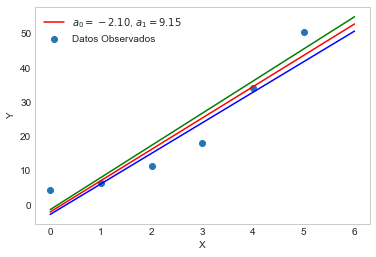

In [12]:
#Ahora graficamos.

a0_estimated = mean_[0]
a1_estimated = mean_[1]

Xtest = np.linspace(0.,6.,100)
Yfit = Model1(Xtest, a0_estimated, a1_estimated)
YfitUp = Model1(Xtest,a0_estimated+EUp[0], a1_estimated+EUp[1])
YfitDown = Model1(Xtest, a0_estimated-EDown[0], a1_estimated-EDown[1])

plt.scatter(X, YObs, label="Datos Observados")
plt.plot(Xtest, Yfit, c='r', label=r"$a_0= {:.2f}$, $a_1={:.2f}$".format(a0_estimated, a1_estimated))
plt.plot(Xtest, YfitUp, c='g')
plt.plot(Xtest, YfitDown, c='b')

plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.legend(loc=0)
plt.show() 

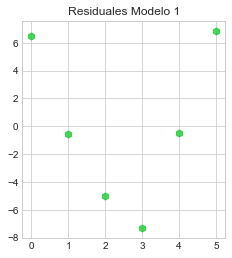

In [13]:
f=plt.figure(figsize=(8,4))
ax1 = f.add_subplot(121,title="Residuales Modelo 1" )
ax1.scatter(X,YObs-Model1(X, a0_estimated, a1_estimated),s=50,marker="h",color=(0.1,0.8,0.2,0.8))

b) Modelo 2: $a_{0}+a_{1}x+a_{2}x^{2}$ <br />

In [14]:
#Definimos la función correspondiente al modelo 2 con su respectiva función de costo y algoritmo de Metrópolis-Hastings.
def Model2(x,a0,a1,a2):
    return a0+a1*x+a2*(x**2)

def Chi2(a0,a1,a2):
    Y_fit = Model2(X,a0,a1,a2)
    
    chi2 = 0.
    
    for i in range(len(X)):
        chi2 += (YObs[i]-Y_fit[i])**2/(2*Sigma[i]**2)
    
    return chi2

Chi2 = np.vectorize(Chi2)

def Metropolis(a00_,a10_,a20_, WidthSteps, NSteps):
    
    mcmc_steps = []
    
    burn_steps = 5000
    
    for i in tqdm(range(NSteps)):
        
        # Present
        P0 = np.exp(-Chi2(a00_,a10_,a20_))
        
        a0n_ = a00_ + WidthSteps*2.*(np.random.rand()-0.5)
        a1n_ = a10_ + WidthSteps*2.*(np.random.rand()-0.5)
        a2n_ = a20_ + WidthSteps*2.*(np.random.rand()-0.5)
        
        Pn = np.exp(- Chi2(a0n_,a1n_,a2n_))
        
        alpha = Pn/P0
        
        beta = np.random.rand()
        
            
        if np.minimum(1, alpha > beta):
                
            a00_ = a0n_
            a10_ = a1n_
            a20_ = a2n_
                
        if (i >= burn_steps):
            mcmc_steps.append([a00_,a10_,a20_]) 
        
        else:
            if (i >= burn_steps):
                mcmc_steps.append([a00_,a10_,a20_])  
    
    
    mcmc_steps = np.array(mcmc_steps)
    return mcmc_steps

#Calculamos e imprimimos los coeficientes óptimos encontrados con sus respectivos errores superiores e inferiores.

mcmc = Metropolis(3.,0.1,2,0.3,50000)

a0= mcmc[:,0]
a1= mcmc[:,1]
a2 = mcmc[:,2]
mean_ = []
EUp = []
EDown = []
for i in range(3):
    mean=np.percentile(mcmc[:,i],50)
    sigma1 = np.percentile(mcmc[:,i], 16.)
    sigma2 = np.percentile(mcmc[:,i], 84.)
    mean_.append(mean)
    EUp.append(sigma2-mean)
    EDown.append(mean - sigma1)
    display(Latex(r'$\hat{a}_{'+str(i)+'} = '+str(mean)+'_{-' + str(mean-sigma1)+'}'+'^{+'+str(sigma2-mean)+'}$'))


100%|██████████| 50000/50000 [00:13<00:00, 3771.19it/s]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

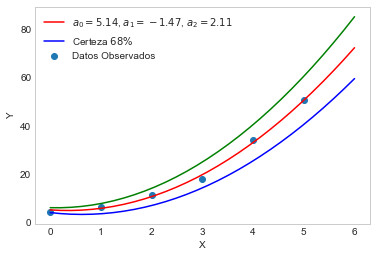

In [15]:
#Ahora graficamos.

a0_estimated = mean_[0]
a1_estimated = mean_[1]
a2_estimated = mean_[2]

Xtest = np.linspace(0.,6.,30)
Yfit = Model2(Xtest, a0_estimated, a1_estimated,a2_estimated)
YfitUp = Model2(Xtest, a0_estimated+EUp[0], a1_estimated+EUp[1],a2_estimated+EUp[2])
YfitDown = Model2(Xtest, a0_estimated-EDown[0], a1_estimated-EDown[1],a2_estimated-EDown[2])

plt.scatter(X, YObs, label="Datos Observados")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.plot(Xtest, Yfit, c='r', label=r"$a_0= {:.2f}$, $a_1={:.2f}$, $a_2={:.2f}$".format(a0_estimated, a1_estimated,a2_estimated))
plt.plot(Xtest, YfitUp, c='g')
plt.plot(Xtest, YfitDown, c='b', label=r'Certeza $68\%$')

plt.legend(loc=0)
plt.show()

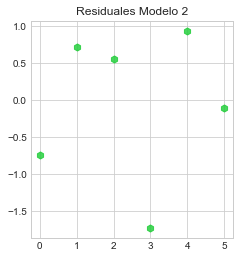

In [16]:
f=plt.figure(figsize=(8,4))
ax1 = f.add_subplot(121,title="Residuales Modelo 2" )
ax1.scatter(X,YObs-Model2(X, a0_estimated, a1_estimated, a2_estimated),s=50,marker="h",color=(0.1,0.8,0.2,0.8))

c) Modelo 3: $a_{0}e^{a_{1}x}$

In [17]:
#Definimos la función correspondiente al modelo 3 con su respectiva función de costo y algoritmo de Metrópolis-Hastings.
def Model3(x,a0,a1):
    return a0*np.exp(a1*x)

def Chi2(a0,a1):
    Y_fit = Model3(X,a0,a1)
    
    chi2 = 0.
    
    for i in range(len(X)):
        chi2 += (YObs[i]-Y_fit[i])**2/(2*Sigma[i]**2)
    
    return chi2

Chi2 = np.vectorize(Chi2)

def Metropolis(a00_,a10_, WidthSteps, NSteps):
    
    mcmc_steps = []
    
    burn_steps = 5000
    
    for i in tqdm(range(NSteps)):
        
        # Present
        P0 = np.exp(-Chi2(a00_,a10_))
        
        a0n_ = a00_ + WidthSteps*2.*(np.random.rand()-0.5)
        a1n_ = a10_ + WidthSteps*2.*(np.random.rand()-0.5)
        
        Pn = np.exp(- Chi2(a0n_,a1n_))
        
        alpha = Pn/P0
        
        beta = np.random.rand()
        
            
        if np.minimum(1, alpha > beta):
                
            a00_ = a0n_
            a10_ = a1n_
                
        if (i >= burn_steps):
            mcmc_steps.append([a00_,a10_]) 
        
        else:
            if (i >= burn_steps):
                mcmc_steps.append([a00_,a10_])  
    
    
    mcmc_steps = np.array(mcmc_steps)
    return mcmc_steps

#Calculamos e imprimimos los coeficientes óptimos encontrados con sus respectivos errores superiores e inferiores.

mcmc = Metropolis(2,1,0.3,50000)

a0= mcmc[:,0]
a1= mcmc[:,1]
mean_ = []
EUp = []
EDown = []
for i in range(2):
    mean=np.percentile(mcmc[:,i],50)
    sigma1 = np.percentile(mcmc[:,i], 16.)
    sigma2 = np.percentile(mcmc[:,i], 84.)
    mean_.append(mean)
    EUp.append(sigma2-mean)
    EDown.append(mean - sigma1)
    display(Latex(r'$\hat{a}_{'+str(i)+'} = '+str(mean)+'_{-' + str(mean-sigma1)+'}'+'^{+'+str(sigma2-mean)+'}$'))

  0%|          | 0/50000 [00:00<?, ?it/s]<ipython-input-17-1685037dc2e6>:33: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = Pn/P0
100%|██████████| 50000/50000 [00:08<00:00, 6128.70it/s]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

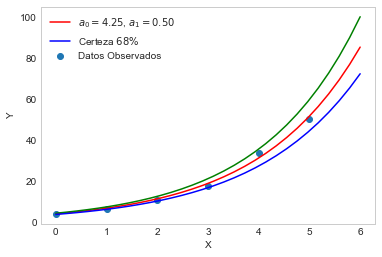

In [18]:
# Ahora graficamos
a0_estimated = mean_[0]
a1_estimated = mean_[1]

Xtest = np.linspace(0.,6.,30)
Yfit = Model3(Xtest, a0_estimated, a1_estimated)
YfitUp = Model3(Xtest,a0_estimated+EUp[0], a1_estimated+EUp[1])
YfitDown = Model3(Xtest, a0_estimated-EDown[0], a1_estimated-EDown[1])

plt.scatter(X, YObs, label="Datos Observados")
plt.plot(Xtest, Yfit, c='r', label=r"$a_0= {:.2f}$, $a_1={:.2f}$".format(a0_estimated, a1_estimated))
plt.plot(Xtest, YfitUp, c='g')
plt.plot(Xtest, YfitDown, c='b', label=r'Certeza $68\%$')
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.legend(loc=0)
plt.show()

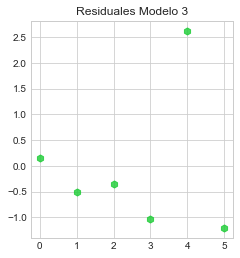

In [19]:
f=plt.figure(figsize=(8,4))
ax1 = f.add_subplot(121,title="Residuales Modelo 3" )
ax1.scatter(X,YObs-Model3(X, a0_estimated, a1_estimated),s=50,marker="h",color=(0.1,0.8,0.2,0.8))

## 6. Máxima Verosimilitud - Estimación de parámetros
**1.** Con los datos de https://github.com/asegura4488/MetodosCompu2021/blob/main/Week7/data/Likelihood.dat trazar las curvas de nivel del logaritmo de la verosimilitud asociados a los dos parámetros de la distribución $\mu$ y $\sigma$. 

In [20]:
# Primero importamos los datos de interés.

file_ = 'data/Likelihood.dat'
data = np.loadtxt(file_, comments='#')
N = len(data)

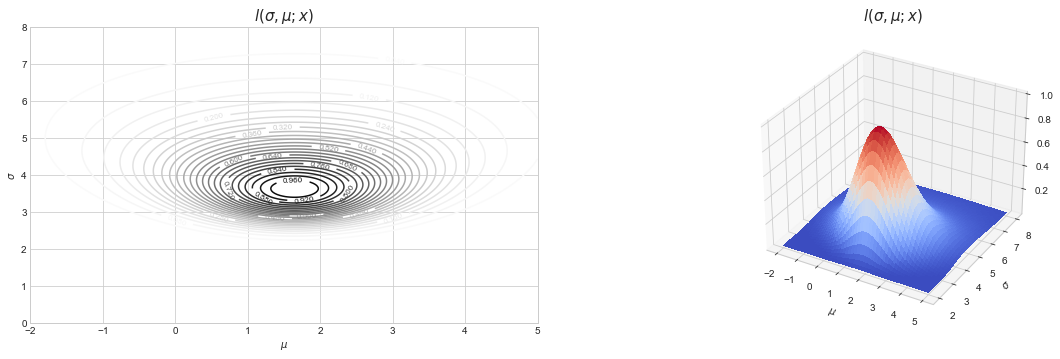

In [49]:
#Definimos las funciones que utilizaremos
#NOTA: A continuación utilizamos la condición sigma^2 > 0

def Likelihood(x_, mu_, sigma_):
            return 1/np.sqrt(2*np.pi*(sigma_**2))*np.exp(-(x_-mu_)**2/(2*(sigma_**2)))

def log_likelihood(mu_, sigma_):
    
    loglikelihood = []
    for i in data:
        loglikelihood.append(np.log(Likelihood(i, mu_, sigma_)))

    return sum(loglikelihood)

# Ahora generamos los datos y graficamos.

log_likelihood = np.vectorize(log_likelihood)
sigma_ = np.linspace(2,8,200)
mu_ = np.linspace(-2,5.,200)
mu, sigma = np.meshgrid(mu_,sigma_)
likelihood = log_likelihood( mu, sigma)

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(221)
c = ax.contour(mu,sigma,np.exp(likelihood-likelihood.max()) ,25)
ax.clabel(c, inline=1, fontsize=8)
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_xlim(-2,5)
ax.set_ylim(0,8)
ax.set_title(r"$l(\sigma, \mu ; x)$", fontsize = 15)


ax1 = fig.add_subplot(222, projection='3d')
surf = ax1.plot_surface(mu, sigma, np.exp(likelihood-likelihood.max()), cmap=cm.coolwarm ,linewidth=0, antialiased=False)
ax1.set_xlabel('$\mu$')
ax1.set_ylabel('$\sigma$')
ax1.set_title(r"$l(\sigma, \mu ; x)$", fontsize = 15 )
plt.show()

**2.** Para esta muestra de datos ¿cuál es el valor aproximado de $\mu$ y de $\sigma$?

In [48]:
# Ahora hallamos los valores aproximados de mu y sigma correspondientes a la máxima verosimilitud.

ii = np.where(np.exp(likelihood-likelihood.max()) == np.amax(np.exp(likelihood-likelihood.max())))
likelihoodmax_ = likelihood[ii][0]
sigmamax, mumax = sigma_[ii[0]][0], mu_[ii[1]][0]
mu_teo = np.average(data)
sigma_teo = np.sqrt(np.average((data-mu_teo)**2))

display(Latex(r'$\hat{\mu} = '+str(mumax) + '\quad \quad \quad'+'\hat{\sigma} = '+str(sigmamax) +'$'))

<IPython.core.display.Latex object>

Por otro lado, analíticamente al calcular el máximo del logaritmo de la función likelihood de la distribución normal:
$$
\ln(L(x_{1},...,x_{n} | \mu, \sigma ) =-n \ln (\sqrt{2\pi})-n \ln(\sigma) - \sum_{i=1}^{n} \frac{(x_{i}-\mu)^{2}}{2\sigma^{2}}
$$
Encontramos que:
$$
\hat{\mu} = \frac{1}{n} \sum_{i=1}^{n}x_{i} \quad    \quad \quad \quad \hat{\sigma} = \sqrt{\frac{1}{n} \sum_{i=1}^{n}(x_{i}-\hat{\mu})^{2}}
$$
Para el conjunto de datos estudiado, al utilizar este análisis encontramos que los valores teóricos de $\mu$ y $\sigma$ correspondientes a la máxima verosimilitud son:
$$
\hat{\mu} = 1.6461228522199491  \quad \quad \quad \hat{\sigma} = 3.619291789654469
$$
